In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('realty.csv', index_col=['date'])
prices.head(10)

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
03-01-2018  258.299988     710.750000     479.600006     618.250000   
04-01-2018  257.500000     714.750000     487.450012     580.599976   
05-01-2018  259.950012     725.250000     489.700012     575.099976   
08-01-2018  260.250000     736.950012     493.450012     585.650024   
09-01-2018  269.850006     791.549988     506.700012     602.549988   
10-01-2018  269.350006     826.349976     528.000000     589.500000   
11-01-2018  270.500000     844.599976     555.250000     606.650024   
12-01-2018  268.549988     834.750000     532.700012     595.250000   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
03-01-2018   321.000000  205.300003    216.000000  603.250000  414.450012  
04-01-2018   338.600006  205.100006    219.250000  610.000000  415.600006  
05-01-2018   335.049988  205.500000    221.250000  605.549988  413.149994  
08-01-2018   332.399994  209.000000    229.250000  599.799988  413.399994  
09-01-2018   333.750000  208.533341    235.850006  606.000000  409.750000  
10-01-2018   334.049988  208.100006    247.100006  604.400024  409.899994  
11-01-2018   345.000000  210.199997    255.649994  605.349976  406.549988  
12-01-2018   337.950012  210.266663    253.600006  592.400024  404.700012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
30-12-2020  235.949997    1393.750000     567.950012     763.049988   
31-12-2020  232.850006    1432.150024     583.400024     774.549988   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
30-12-2020   264.899994  246.100006     79.300003  382.500000  356.049988  
31-12-2020   266.100006  249.100006     82.199997  414.649994  347.950012

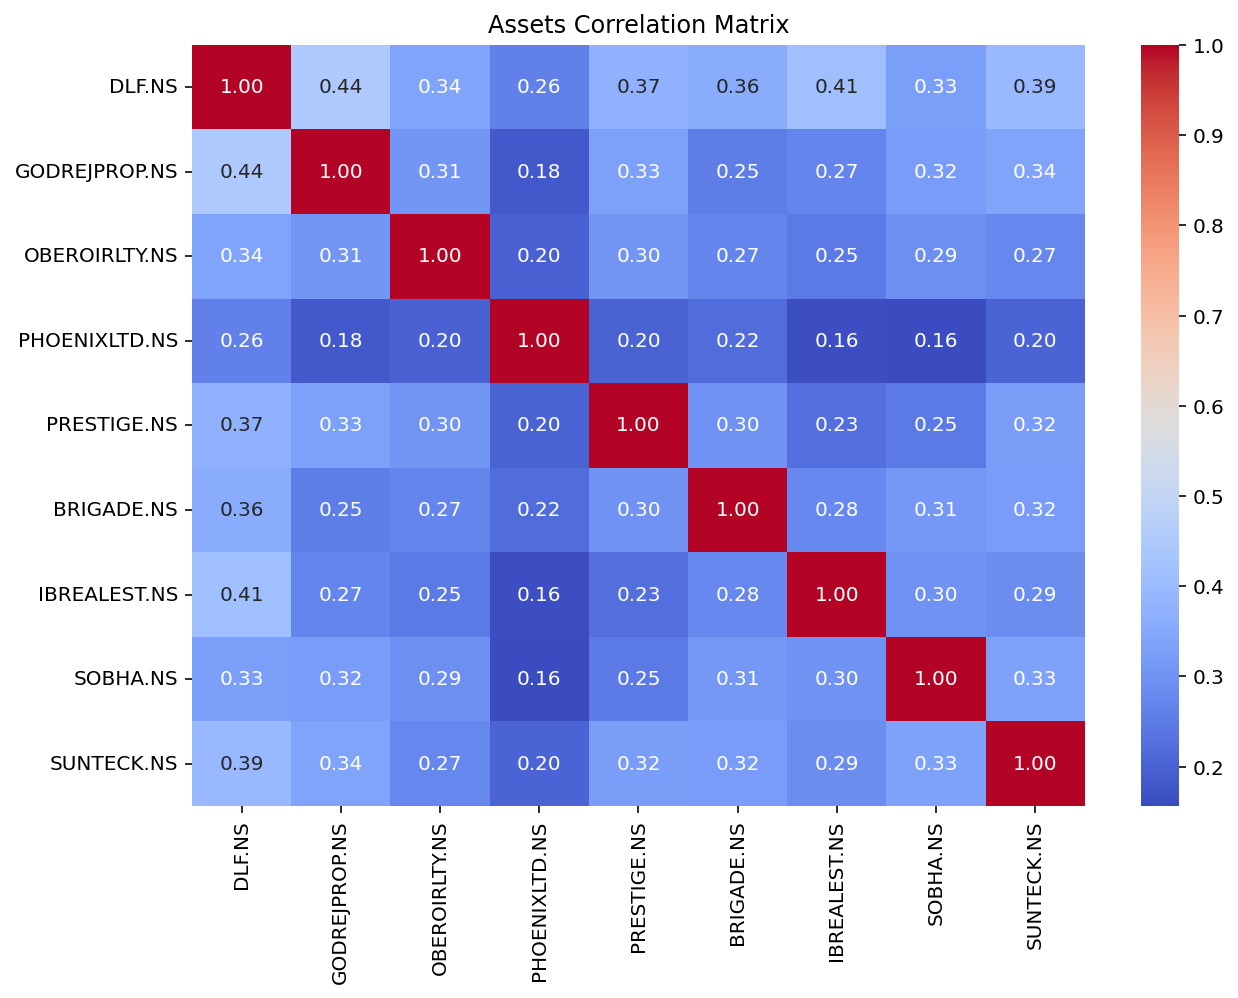

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

[('DLF.NS', 'OBEROIRLTY.NS'), ('OBEROIRLTY.NS', 'PRESTIGE.NS'), ('OBEROIRLTY.NS', 'SOBHA.NS'), ('OBEROIRLTY.NS', 'SUNTECK.NS'), ('PHOENIXLTD.NS', 'PRESTIGE.NS'), ('PHOENIXLTD.NS', 'BRIGADE.NS')]


### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'PHOENIXLTD.NS'
asset2 = 'PRESTIGE.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

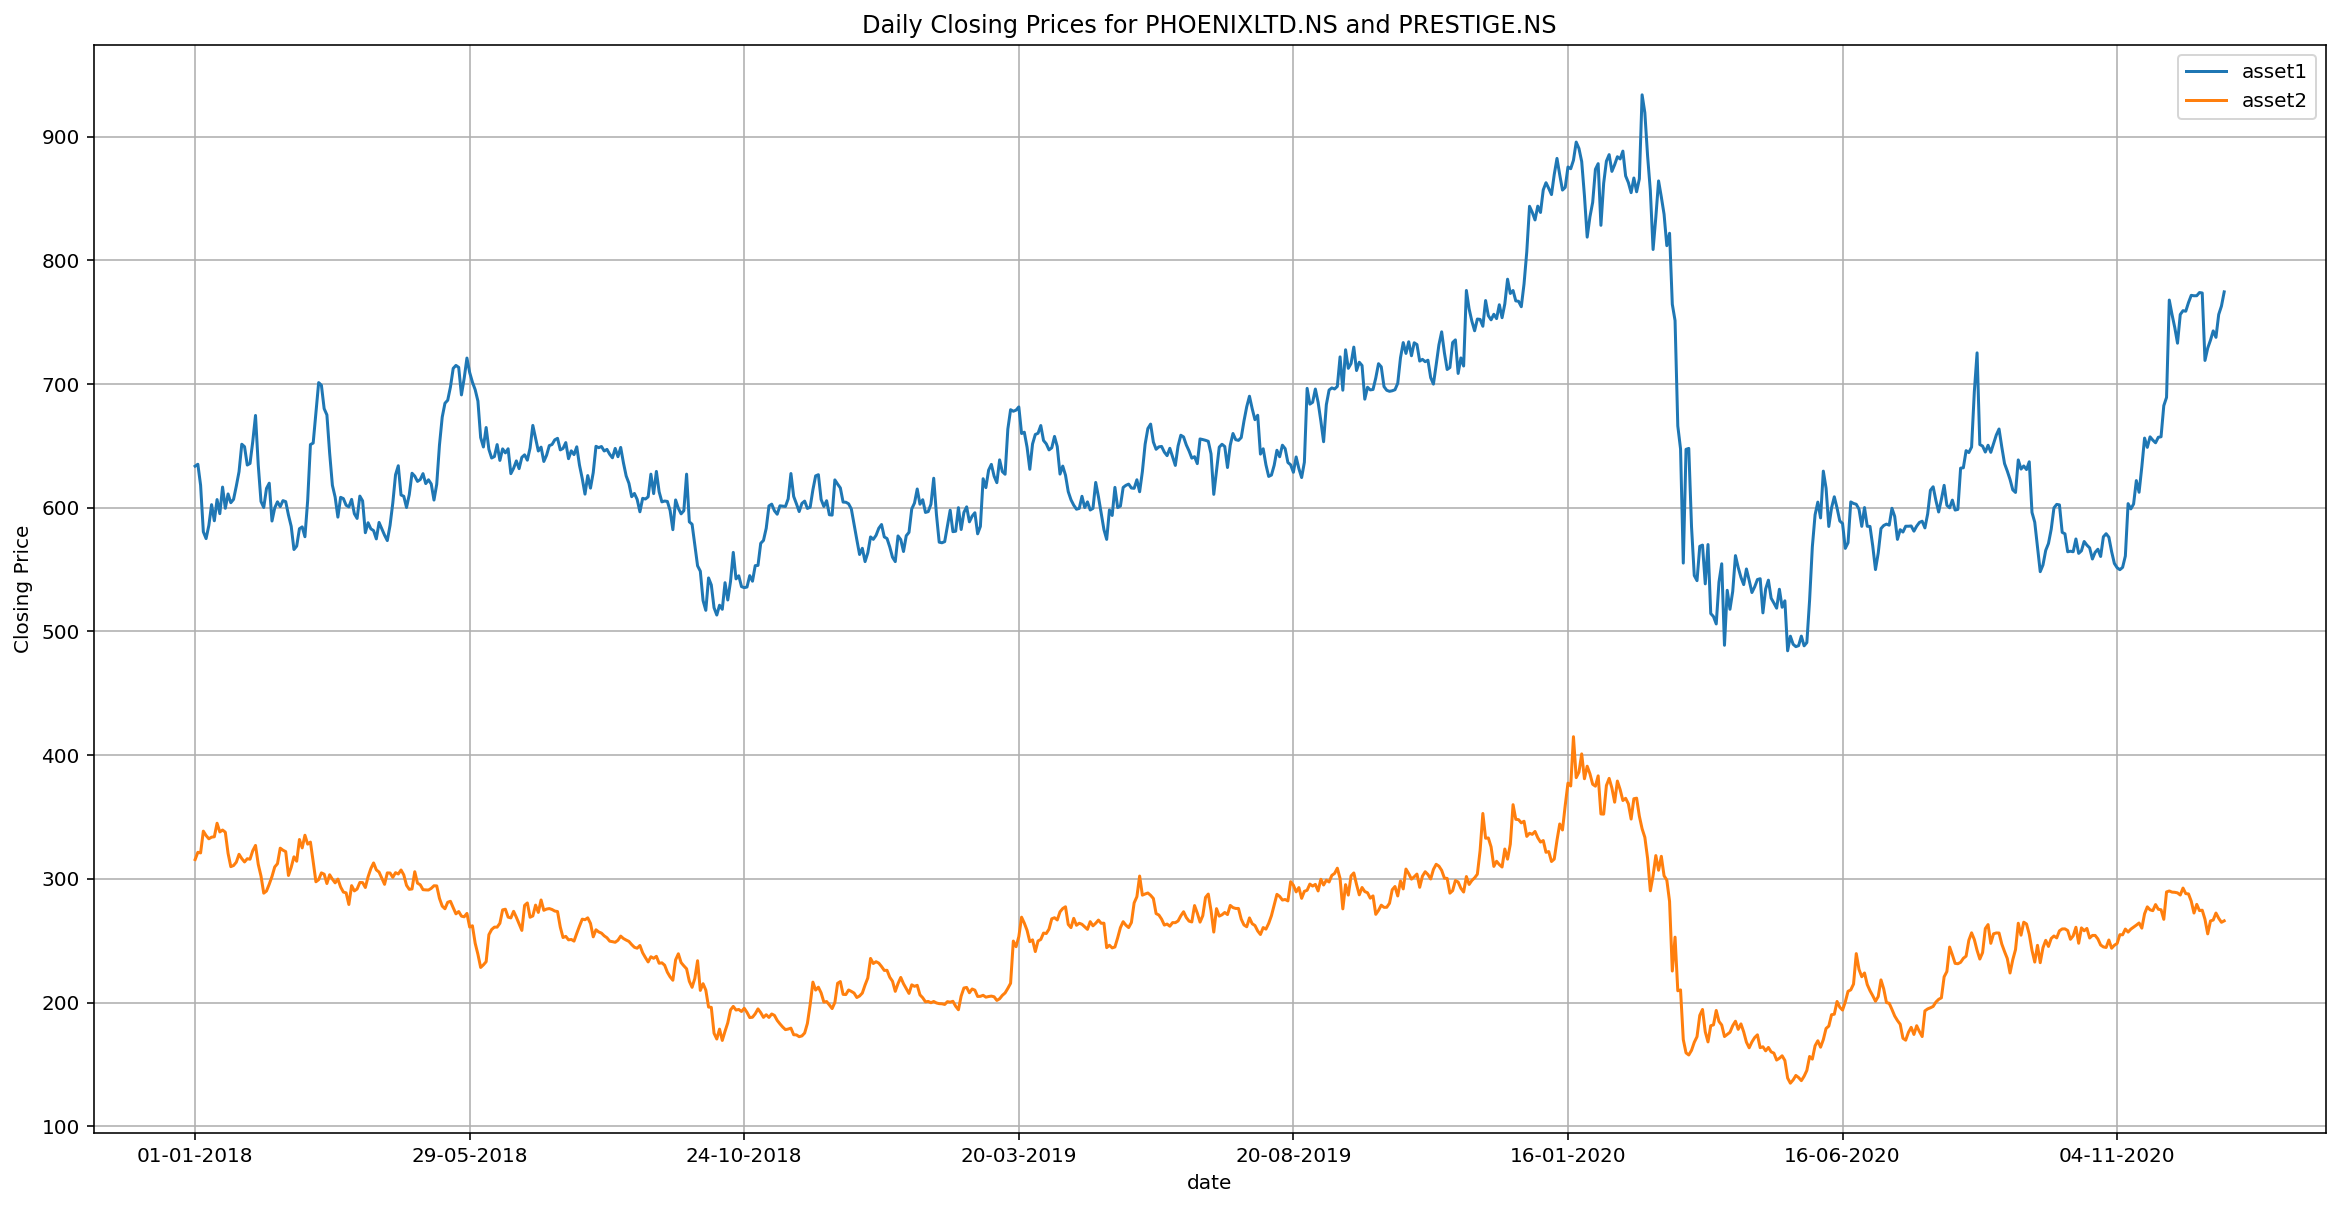

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          3.802e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:49:32   Log-Likelihood:                         -3707.8
No. Observations:                 740   AIC:                                      7418.
Df Residuals:                     739   BIC:                                      7422.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.4012      0.002    194.984      0.000       0.397       0.405
==============================================================================
Omnibus:                       10.223   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.357
Skew:                           0.289   Prob(JB):                      0.00564
Kurtosis:                       3.031   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

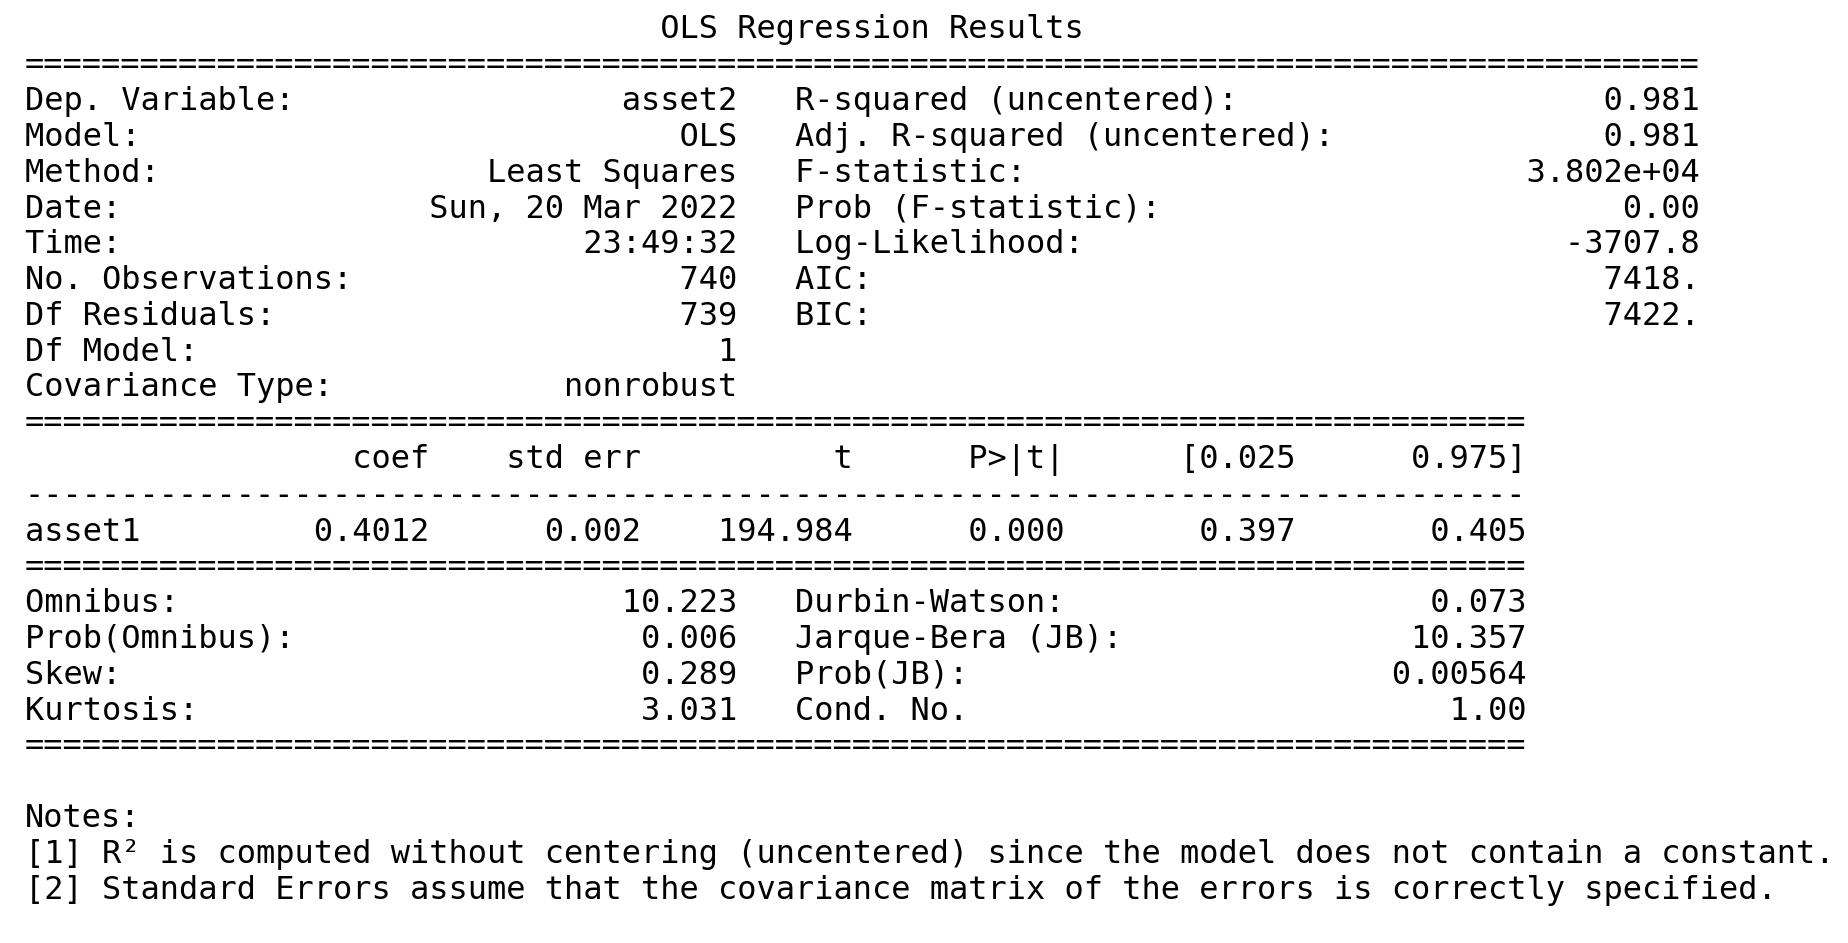

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.40123892689086327


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

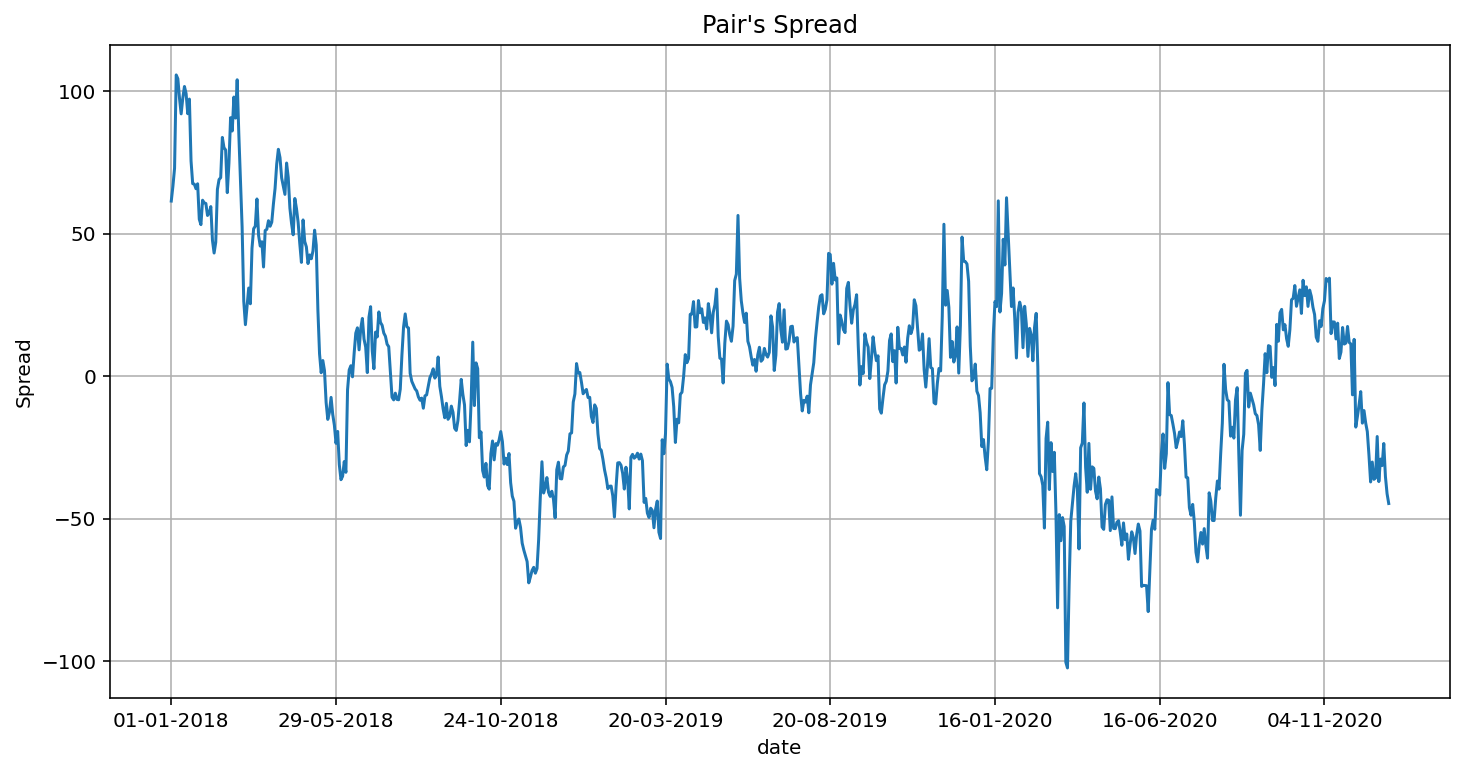

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.5467829019128096,
 0.006863824693737367,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5448.679316669209)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.5467829019128096


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  785.450012  266.799988
04-01-2021  773.599976  272.950012
05-01-2021  763.849976  275.299988
06-01-2021  767.349976  280.899994
07-01-2021  753.099976  282.600006

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  785.450012  266.799988  1.451460            1.0           -1.0
04-01-2021  773.599976  272.950012  1.086632            1.0           -1.0
05-01-2021  763.849976  275.299988  0.888476            1.0           -1.0
06-01-2021  767.349976  280.899994  0.746017            1.0           -1.0
07-01-2021  753.099976  282.600006  0.523764            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

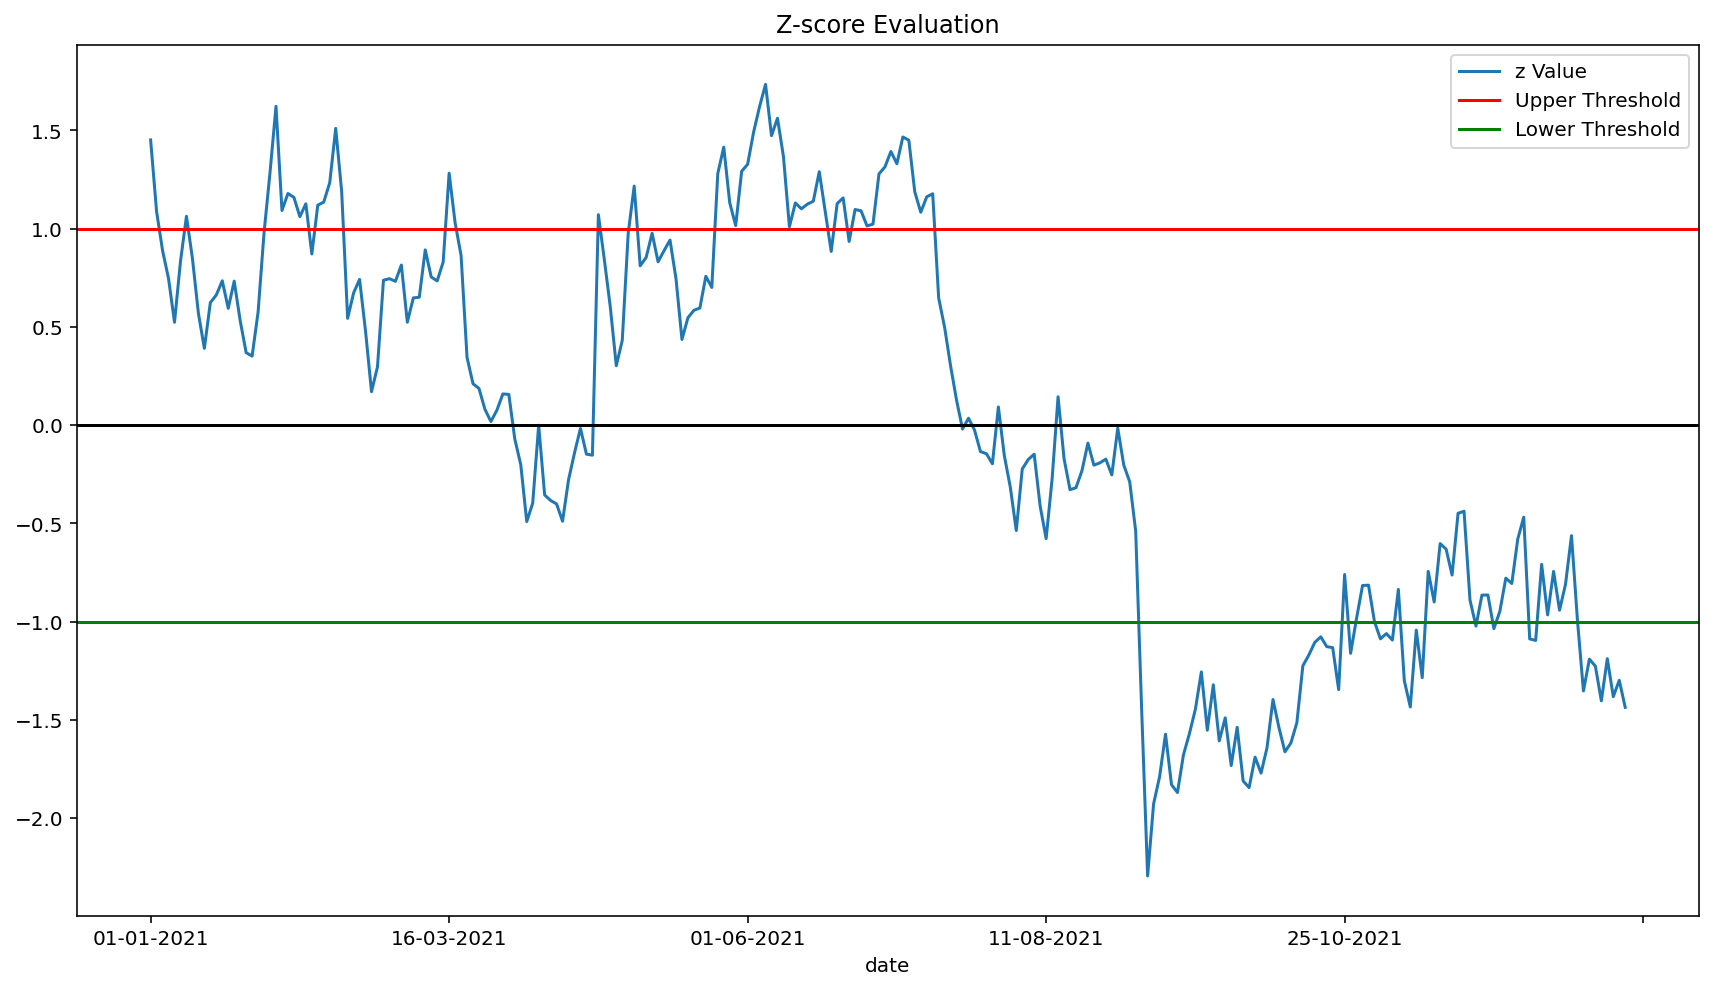

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  785.450012  266.799988  1.451460            1.0           -1.0   
04-01-2021  773.599976  272.950012  1.086632            1.0           -1.0   
05-01-2021  763.849976  275.299988  0.888476            1.0           -1.0   
29-12-2021  991.950012  474.200012 -1.381231            1.0           -1.0   
30-12-2021  987.400024  466.450012 -1.298120            1.0           -1.0   
31-12-2021  985.349976  474.750000 -1.435501            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  785.450012  266.799988  1.451460            1.0           -1.0   
04-01-2021  773.599976  272.950012  1.086632            1.0           -1.0   
11-01-2021  822.549988  290.950012  1.063028            1.0           -1.0   
01-02-2021  806.950012  278.799988  1.286587            1.0           -1.0   
02-02-2021  851.450012  284.250000  1.622529            1.0           -1.0   
03-02-2021  823.150024  290.250000  1.092566            1.0           -1.0   
04-02-2021  809.099976  282.700012  1.179132            1.0           -1.0   
05-02-2021  802.849976  281.100006  1.159375            1.0           -1.0   
08-02-2021  800.750000  283.299988  1.061004            1.0           -1.0   
09-02-2021  804.500000  282.649994  1.126715            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
11-01-2021        -1        -1.0         1         1.0  
01-02-2021        -1        -1.0         1         1.0  
02-02-2021        -1         0.0         1         0.0  
03-02-2021        -1         0.0         1         0.0  
04-02-2021        -1         0.0         1         0.0  
05-02-2021        -1         0.0         1         0.0  
08-02-2021        -1         0.0         1         0.0  
09-02-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   785.450012  266.799988  1.451460            1.0           -1.0   
05-01-2021   763.849976  275.299988  0.888476            1.0           -1.0   
11-01-2021   822.549988  290.950012  1.063028            1.0           -1.0   
12-01-2021   819.299988  296.549988  0.849125            1.0           -1.0   
01-02-2021   806.950012  278.799988  1.286587            1.0           -1.0   
01-12-2021   972.250000  442.750000 -1.035190            1.0           -1.0   
02-12-2021   992.000000  446.350006 -0.946975            1.0           -1.0   
09-12-2021  1019.250000  467.500000 -1.087449            1.0           -1.0   
13-12-2021  1056.800049  460.600006 -0.707869            1.0           -1.0   
22-12-2021   959.750000  456.899994 -1.352209            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-01-2021         0         1.0         0        -1.0  
11-01-2021        -1        -1.0         1         1.0  
12-01-2021         0         1.0         0        -1.0  
01-02-2021        -1        -1.0         1         1.0  
01-12-2021         1         1.0        -1        -1.0  
02-12-2021         0        -1.0         0         1.0  
09-12-2021         1         1.0        -1        -1.0  
13-12-2021         0        -1.0         0         1.0  
22-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

763.849976     1
819.299988     1
1019.250000    1
972.250000     1
968.349976     1
1089.500000    1
1010.799988    1
951.950012     1
876.049988     1
860.200012     1
806.450012     1
809.799988     1
747.950012     1
757.799988     1
768.049988     1
832.650024     1
807.849976     1
959.750000     1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   785.450012  266.799988  1.451460            1.0           -1.0   
04-01-2021   773.599976  272.950012  1.086632            1.0           -1.0   
05-01-2021   763.849976  275.299988  0.888476            1.0           -1.0   
06-01-2021   767.349976  280.899994  0.746017            1.0           -1.0   
07-01-2021   753.099976  282.600006  0.523764            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021   995.900024  477.549988 -1.402515            1.0           -1.0   
28-12-2021  1028.449951  478.350006 -1.187906            1.0           -1.0   
29-12-2021   991.950012  474.200012 -1.381231            1.0           -1.0   
30-12-2021   987.400024  466.450012 -1.298120            1.0           -1.0   
31-12-2021   985.349976  474.750000 -1.435501            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

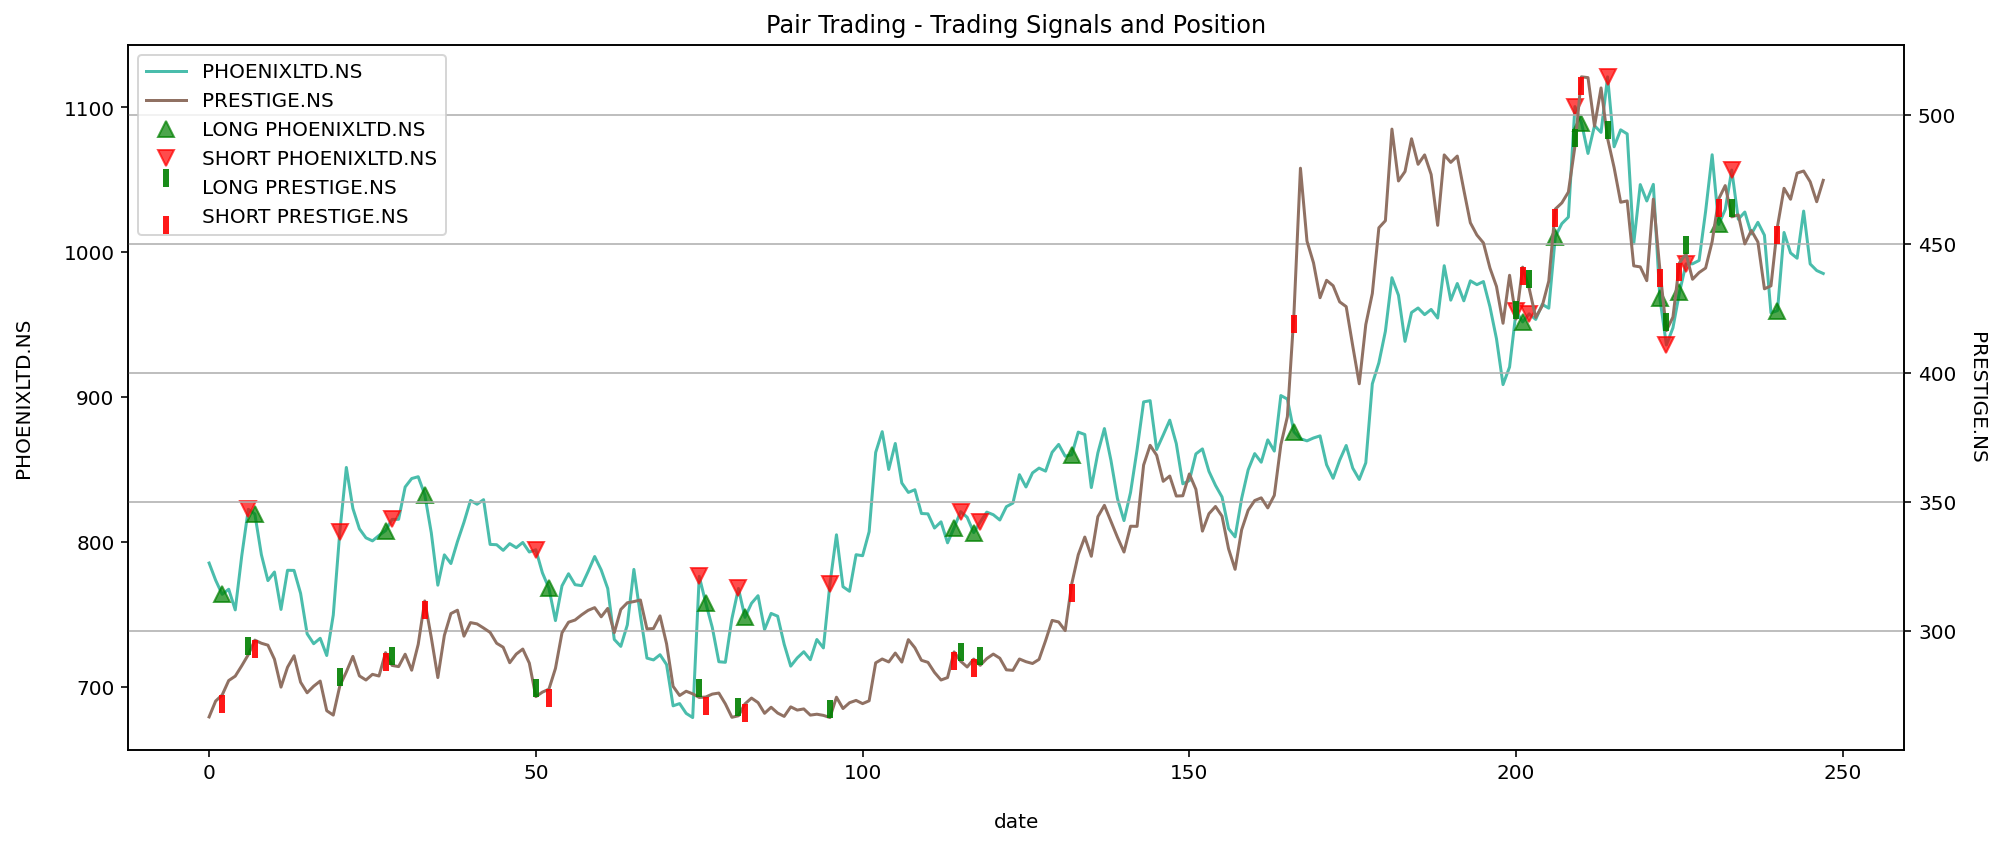

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     785.450012            NaN            NaN            NaN       NaN   
1     773.599976       0.000000  100000.000000  100000.000000       NaN   
2     763.849976   67982.647828   32017.352172  100000.000000  0.000000   
3     767.349976   68294.147828   32017.352172  100311.500000  0.003115   
4     753.099976   67025.897828   32017.352172   99043.250000 -0.012643   
243   995.900024  177270.204343  -34278.739142  142991.465201 -0.004523   
244  1028.449951  183064.091278  -34278.739142  148785.352136  0.040519   
245   991.950012  176567.102172  -34278.739142  142288.363030 -0.043667   
246   987.400024  175757.204343  -34278.739142  141478.465201 -0.005692   
247   985.349976  175392.295657  -34278.739142  141113.556515 -0.002579   

     positions1  
0           NaN  
1           0.0  
2           1.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   785.450012           NaN            NaN            NaN       NaN   
2   763.849976  67982.647828   32017.352172  100000.000000  0.000000   
6   822.549988      0.000000  105224.301086  105224.301086  0.027774   
7   819.299988  72917.698914   32306.602172  105224.301086  0.000000   
20  806.950012      0.000000  104125.153257  104125.153257  0.051593   

    positions1  
0          NaN  
2          1.0  
6         -1.0  
7          1.0  
20        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     785.450012            NaN            NaN            NaN       NaN   
1     773.599976       0.000000  100000.000000  100000.000000       NaN   
2     763.849976   67982.647828   32017.352172  100000.000000  0.000000   
3     767.349976   68294.147828   32017.352172  100311.500000  0.003115   
4     753.099976   67025.897828   32017.352172   99043.250000 -0.012643   
243   995.900024  177270.204343  -34278.739142  142991.465201 -0.004523   
244  1028.449951  183064.091278  -34278.739142  148785.352136  0.040519   
245   991.950012  176567.102172  -34278.739142  142288.363030 -0.043667   
246   987.400024  175757.204343  -34278.739142  141478.465201 -0.005692   
247   985.349976  175392.295657  -34278.739142  141113.556515 -0.002579   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  266.799988            NaN            NaN            NaN   
1           0.0  272.950012       0.000000  100000.000000  100000.000000   
2           1.0  275.299988  -53408.197633  153408.197633  100000.000000   
3           0.0  280.899994  -54494.598817  153408.197633   98913.598817   
4           0.0  282.600006  -54824.401183  153408.197633   98583.796450   
243         0.0  477.549988 -185289.395266  270273.802367   84984.407100   
244         0.0  478.350006 -185599.802367  270273.802367   84674.000000   
245         0.0  474.200012 -183989.604734  270273.802367   86284.197633   
246         0.0  466.450012 -180982.604734  270273.802367   89291.197633   
247         0.0  474.750000 -184203.000000  270273.802367   86070.802367   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000        -1.0  
3   -0.010864         0.0  
4   -0.003334         0.0  
243 -0.044288         0.0  
244 -0.003653         0.0  
245  0.019016         0.0  
246  0.034850         0.0  
247 -0.036066         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   785.450012           NaN            NaN            NaN       NaN   
2   763.849976  67982.647828   32017.352172  100000.000000  0.000000   
6   822.549988      0.000000  105224.301086  105224.301086  0.027774   
7   819.299988  72917.698914   32306.602172  105224.301086  0.000000   
20  806.950012      0.000000  104125.153257  104125.153257  0.051593   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  266.799988           NaN            NaN            NaN   
2          1.0  275.299988 -53408.197633  153408.197633  100000.000000   
6         -1.0  290.950012      0.000000   96963.895266   96963.895266   
7          1.0  296.549988 -57530.697633  154494.592900   96963.895266   
20        -1.0  278.799988      0.000000  100407.395266  100407.395266   

         return2  positions2  
0            NaN         NaN  
2   0.000000e+00        -1.0  
6  -8.529854e-03         1.0  
7  -1.110223e-16        -1.0  
20 -2.136653e-02         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

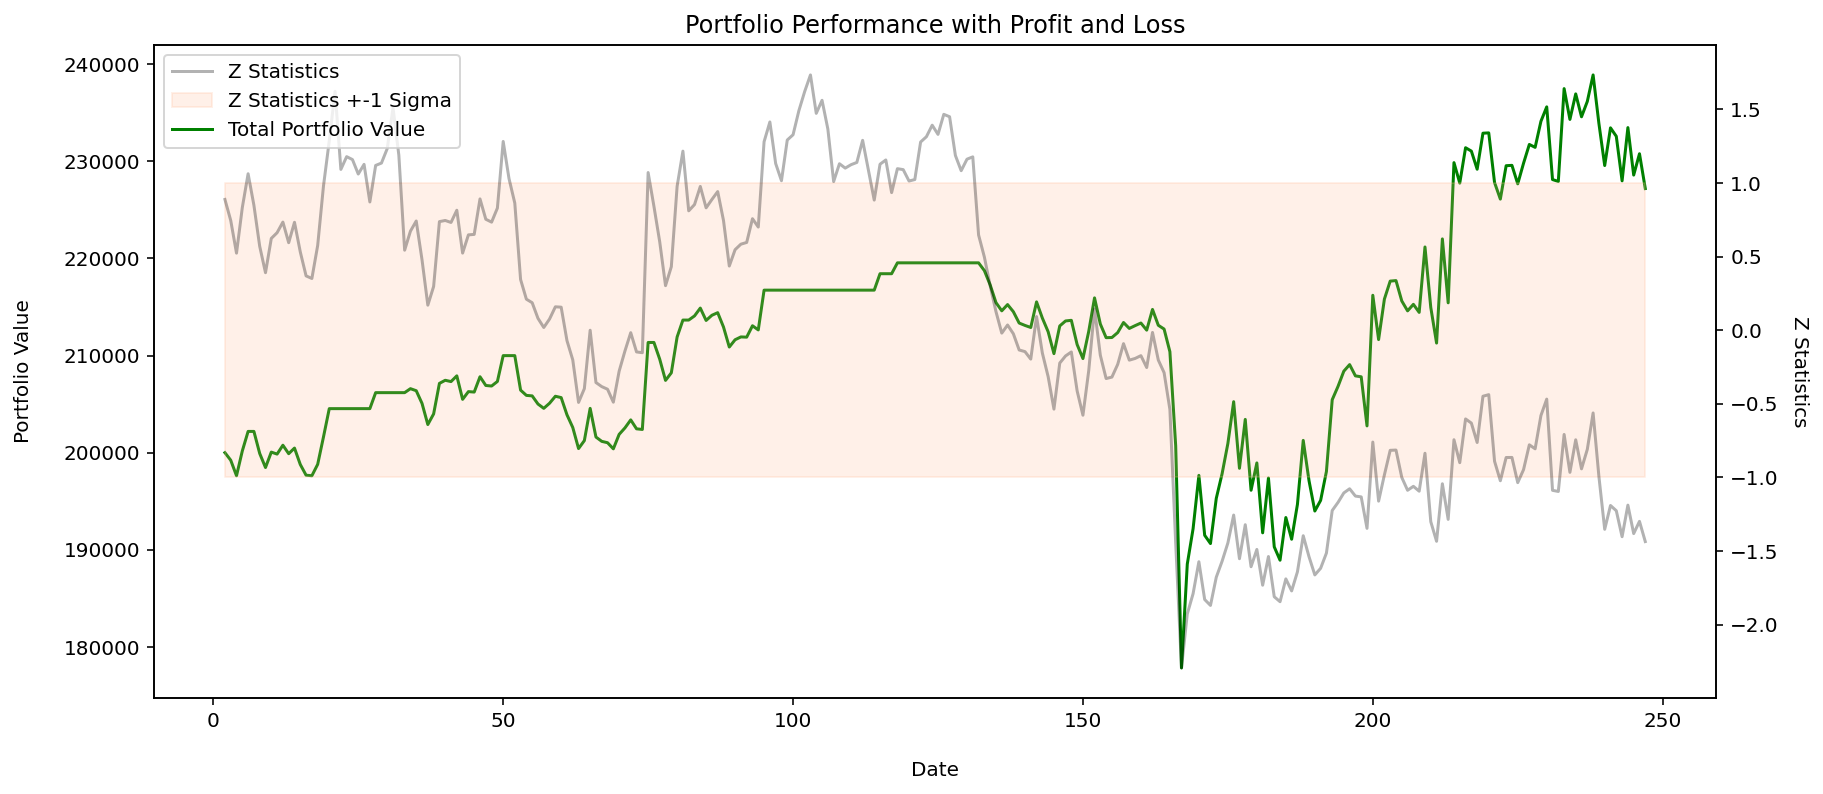

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

227184.3588816

In [46]:
profit = final_portfolio - 2*initial_capital
profit

27184.358881599997

In [47]:
roi = (profit/(2*initial_capital))*100
roi

13.592179440799997

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 239.571%
